#1. Mount Drive

In [38]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import IPython

In [39]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [40]:
!cp -r /gdrive/MyDrive/Darknet/Custom/Traffic/ .

In [41]:
!ls -al ./trafficsign

ls: cannot access './trafficsign': No such file or directory


In [42]:
weight_file = './Traffic/traffic-sign-yolo-final.weights'
cfg_file = './Traffic/traffic-sign-yolo.cfg'
name_file = './Traffic/classes.names'

min_confidence = 0.5

In [43]:
# Load Yolo
net = cv2.dnn.readNet(weight_file, cfg_file)

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [44]:
classes = []
with open(name_file, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
print(classes)

['Prohibitory', 'Danger', 'Mandatory', 'Other']


In [45]:
frame_count = 0
writer = None
input_name = './Traffic/traffic-sign-video.avi'
output_name = 'traffic-sign-video.avi'
file_name = './Traffic/00000.ppm' 
# file_name = './Traffic/00000.png'



In [46]:
# img = cv2.imread(file_name)
# height, width, channels = img.shape
# cv2_imshow(img)
# print(height, width)

# 훈련한 모델이 Recognition Model 이기 때문에 Detection 은 안된다!

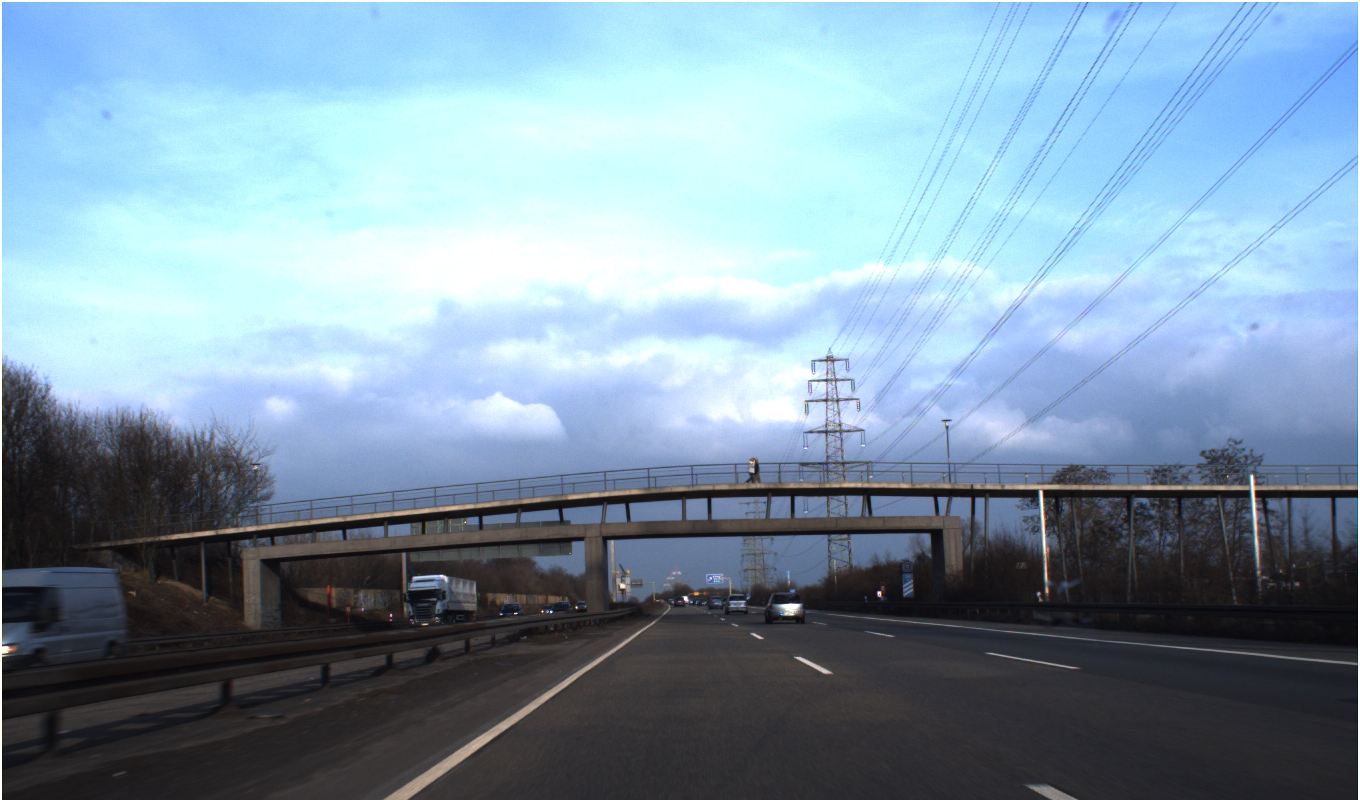

In [47]:
img = cv2.imread(file_name)
height, width, channels = img.shape
# Detecting objects
# https://docs.opencv.org/master/d6/d0f/group__dnn.html
blob = cv2.dnn.blobFromImage(img, 0.00392, (416, 416), (0, 0, 0), True, crop=False)

net.setInput(blob)
outs = net.forward(output_layers)

class_ids = []
confidences = []
boxes = []

for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > min_confidence:
            # Object detected
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)

            # Rectangle coordinates
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)

            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)
font = cv2.FONT_HERSHEY_COMPLEX
for i in range(len(boxes)):
    if i in indexes:
        x, y, w, h = boxes[i]
        label = str(classes[class_ids[i]])
        print(class_ids[i], label)
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(img, label, (x, y - 10), font, 0.5, (0, 255, 0), 1)  
cv2_imshow(img)  

In [ ]:
def writeFrame(img):
  global writer 
  height,width = img.shape[:2]
  if(writer is None and output_name is not None):
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    writer = cv2.VideoWriter(output_name, fourcc, 24, (width, height), True)
    if(writer is not None):
      writer.write(img)

In [50]:
def detectAndDisplay(frame):
    IPython.display.clear_output(wait=True)
    height, width, channedls = frame.shape
    
    # Detecting objects
    # https://docs.opencv.org/master/d6/d0f/group__dnn.html
    blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            # detection[:4] : 박스 정보
            # detection[5:] : 라벨 스코어 (OneHot)
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > min_confidence:
                # Object detected
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)

                # Rectangle coordinates
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)

                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    # NMSBoxes : Detection 결과 겹치는 박스 많으면 생략하게 박스 처리
    indexes = cv2.dnn.NMSBoxes(boxes, confidences, min_confidence, 0.4)
    font = cv2.FONT_HERSHEY_COMPLEX
    for i in range(len(boxes)):
        if i in indexes:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            print(i, label)
            # color = colors[i]
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0,255,0), 2)
            cv2.putText(frame, label, (x, y - 10), font, 0.5, (0, 255, 0), 1)  
    cv2_imshow(frame) 
    # cv2.waitKey(33) # 33ms 지연, 30fps
    writeFrame(frame)
    # 

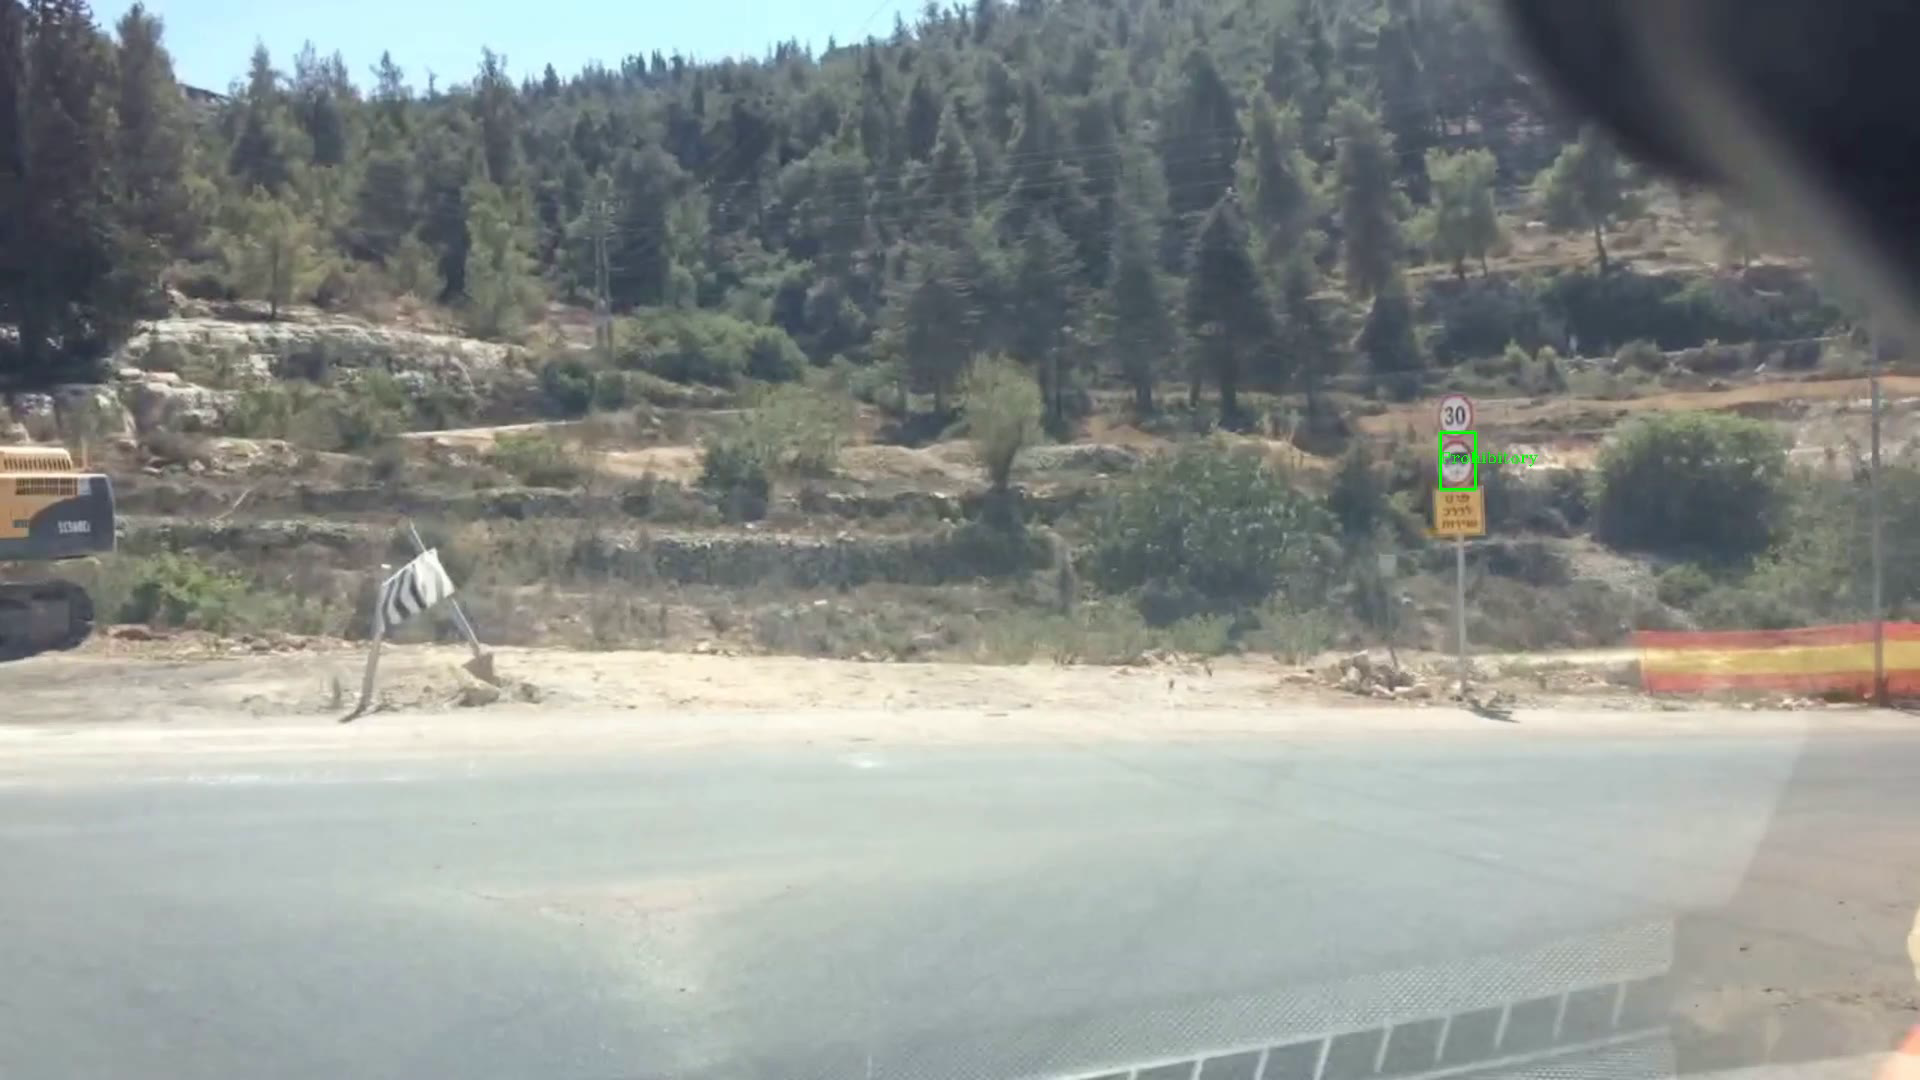

In [ ]:
cap = cv2.VideoCapture(input_name)
if not cap.isOpened:
    print("Erro Open VideoCapture")
    exit(0)
try :
    while True:
        ref, frame = cap.read()
        if frame is None:
            cv2.destroyAllWindows()
            print("No captured frame --Break")
            break
        detectAndDisplay(frame)
        if cv2.waitKey(1) == 27:
            cap.release()
            cv2.destroyAllWindows()
            break
        
except KeyboardInterrupt:
    print("KeyboardInterrupt")

In [ ]:
from google.colab import files
files.download(output_name)